# Adatelemzés a szociális médiában - Projektmunka
## Készítette: Varga Dominik, Horváth Dávid
---
### Feladatunk az volt, hogy adatokat nyerjünk ki a 2018-as Data Science kérdőívből a Kaggle oldalán, és meghatározzuk, mely tényezők befolyásolják   leginkább az adattudósok fizetését. Emellett további érdekes adatokat is megszereztünk, amelyek hasznosak lehetnek számunkra.


# Előkészületek

Kaggle install és csv-k importálása

---



In [1]:
#from google.colab import files # fájlfeltöltés esetén futtandó kód
#files.upload()

In [2]:
json = '{"username":"dominikvarga","key":"123c8df73d58eeaac4746021d635d270"}'
with open("/content/kaggle.json", "w") as f:
  f.write(json)

In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kaggle/kaggle-survey-2018

 95% 4.00M/4.20M [00:00<00:00, 15.3MB/s]
100% 4.20M/4.20M [00:00<00:00, 13.8MB/s]


In [8]:
! unzip kaggle-survey-2018

Archive:  kaggle-survey-2018.zip
  inflating: SurveySchema.csv        
  inflating: freeFormResponses.csv   
  inflating: multipleChoiceResponses.csv  


Importok

---



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import textwrap
import seaborn as sns

A letöltött csv-ket beolvassuk DataFrame-ekbe

---



In [10]:
ss = pd.read_csv("/content/SurveySchema.csv", sep=",")

In [11]:
mcr = pd.read_csv("/content/multipleChoiceResponses.csv", sep=",")

<ipython-input-11-460815c779e9>:1: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  mcr = pd.read_csv("/content/multipleChoiceResponses.csv", sep=",")


In [12]:
ffr = pd.read_csv("/content/freeFormResponses.csv", sep=",")

<ipython-input-12-94a3dbfafe17>:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  ffr = pd.read_csv("/content/freeFormResponses.csv", sep=",")


In [13]:
mcr

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,575,Male,-1,45-49,France,Doctoral degree,"Computer science (software engineering, etc.)",Chief Officer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23856,131,Female,-1,25-29,Turkey,Master’s degree,Engineering (non-computer focused),NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23857,370,Male,-1,22-24,Turkey,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23858,36,Male,-1,25-29,United Kingdom of Great Britain and Northern I...,NaN,NaN,NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


# Adatok elemzése

## Kérdésenkénti kitöltők száma

In [14]:
#@title Segéd függvény a sorrend kialakításához
def question_sorter(data): # Ezzel lehet sorba rendezni a kérdések elnevezését (Q1...Q50)
  helper = []
  for adat in data:
    helper.append(int(adat[1:]))
  helper.sort()
  for x in range(len(helper)):
    helper[x] = "Q" + str(helper[x])
  adatok = pd.CategoricalDtype(helper, ordered=True)
  return adatok

In [15]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
sorrend = question_sorter(ss[1:2].T.iloc[1:-1,0].index)
adatok = ss[1:2].T
adatok.drop(index=adatok.index[0], axis=0, inplace=True)
adatok.drop(index=adatok.index[-1], axis=0, inplace=True)
adatok["kerdesek"] = adatok.index.astype(sorrend)
adatok = adatok.sort_values(by="kerdesek")
adatok[1] = adatok[1].astype(int)

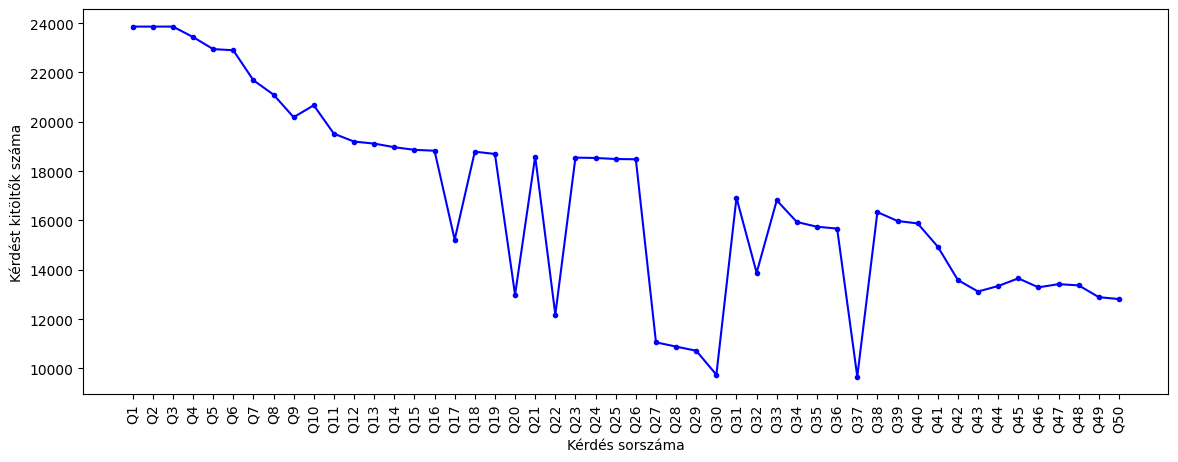

In [16]:
#@title Plot kirajzolása
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(ticks=range(len(adatok.index)))
adatok.plot.line(x='kerdesek', y=1 ,color='blue', ax=ax, style=".-", legend=False, rot=90,xlabel="Kérdés sorszáma", ylabel="Kérdést kitöltők száma", figsize=(14,5))
plt.show()

## A kitöltök száma nemek szerint

<Axes: >

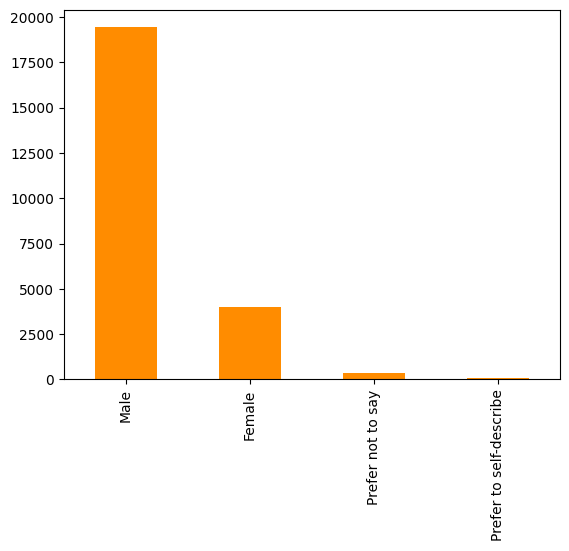

In [17]:
#@title Plot
mcr.Q1[1::].dropna().value_counts().sort_values(ascending=False).plot(kind='bar', color="darkorange")

## Milyen összefüggés van egy data scientist neme és fizetése között?

In [18]:
#@title Segéd függvény a fizetési tartomány sorrendjének kialakításához
def salary_range_sort(data): # Ezt mindenhol lehet használni ahol a fizetési tartományokat kell sorba rendezni
  helper = []
  helper.append(0)
  for adat in data:
    if adat != "500,000+" and adat != "I do not wish to disclose my approximate yearly compensation":
      adat = int(adat.split("-")[1].replace(",",""))
      if adat not in helper:
        helper.append(adat)
  helper.sort()
  vegleges = []
  for x in range(len(helper)-1):
    if len(str(helper[x])) < 6:
      vegleges.append(str(helper[x])[0:2] + "-" + str(helper[x+1])[:-3] + "," + str(helper[x+1])[-3:])
    else:
      vegleges.append(str(helper[x])[0:3] + "-" + str(helper[x+1])[:-3] + "," + str(helper[x+1])[-3:])
  vegleges.insert(0, "I do not wish to disclose my approximate yearly compensation")
  vegleges.append("500,000+")
  vegleges = pd.CategoricalDtype(vegleges, ordered=True)
  return vegleges

In [19]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
nem_fizetes_crt=pd.crosstab(mcr.Q9[1:],mcr.Q1[1:]) # Fizetések crosstab-ja nemekkel
sorrend = salary_range_sort(nem_fizetes_crt.index) # Elnevezések sorba állítása
nem_fizetes_crt["sorrend"] = nem_fizetes_crt.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
nem_fizetes_crt["sorrend"] = nem_fizetes_crt["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
nem_fizetes_crt = nem_fizetes_crt.sort_values(by="sorrend")
nem_fizetes_crt.drop(columns=nem_fizetes_crt.columns[2:], inplace=True) # Eltekintünk az egyéb és nem szeretném válaszolni lehetőségektől
nem_fizetes_crt["Female"] = nem_fizetes_crt["Female"].astype(int)
nem_fizetes_crt["Male"] = nem_fizetes_crt["Male"].astype(int)
#nem_fizetes_crt["Female"] = nem_fizetes_crt["Female"].apply(lambda x: x/(int(nem_fizetes_crt["Female"].shape[0]) +int(nem_fizetes_crt["Male"].shape[0])))
#nem_fizetes_crt["Male"] = nem_fizetes_crt["Male"].apply(lambda x: x/(int(nem_fizetes_crt["Female"].shape[0]) +int(nem_fizetes_crt["Male"].shape[0])))

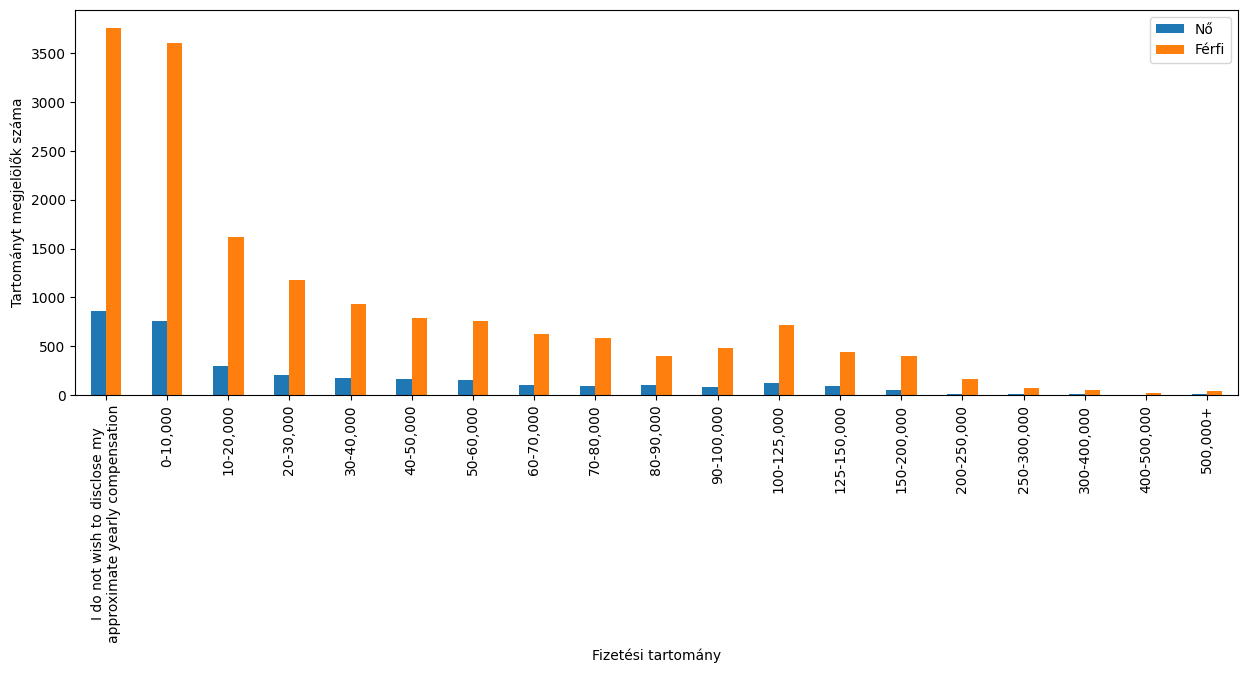

In [20]:
#@title Plot kirajzolása
labels = [textwrap.fill(l,35) for l in nem_fizetes_crt.index]
legend = ["Nő","Férfi"]
ax = nem_fizetes_crt.plot(kind="bar",figsize=(15,5),xlabel="Fizetési tartomány", ylabel="Tartományt megjelölők száma")
ax.set_xticklabels(labels)
ax.legend(legend)
plt.show()

**Fizetések átlaga**

---




In [21]:
#@title Nemek átlagát kiszámoló segéd függvény
def nemek_atlag(adat):
  female_atlag = 0
  male_atlag = 0
  sorrend = salary_range_sort(adat.index) # Elnevezések sorba állítása
  adat["sorrend"] = adat.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
  adat["sorrend"] = adat["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
  adat = adat.sort_values(by="sorrend")
  adat.drop(columns="sorrend", inplace=True)
  atlagok = [5000,15000,25000,35000,45000,55000,65000,75000,85000,95000,112500,137500,175000,225000,275000,350000,450000,500000]
  adat["Female"] = adat["Female"].astype(int)
  adat["Male"] = adat["Male"].astype(int)
  adat["atlagok"] = atlagok
  for i in range(len(adat.index)):
    female_atlag += adat["Female"][i] * adat["atlagok"][i]
    male_atlag += adat["Male"][i] * adat["atlagok"][i]
  female_atlag /= adat["Female"].sum()
  male_atlag /= adat["Male"].sum()
  print(female_atlag)
  print(male_atlag)
  df = pd.DataFrame([round(female_atlag),round(male_atlag)], ["Nők átlag fizetése","Férfiak átlag fizetése"],["Átlagok"])
  return df

44631.3025210084
51190.73527125758


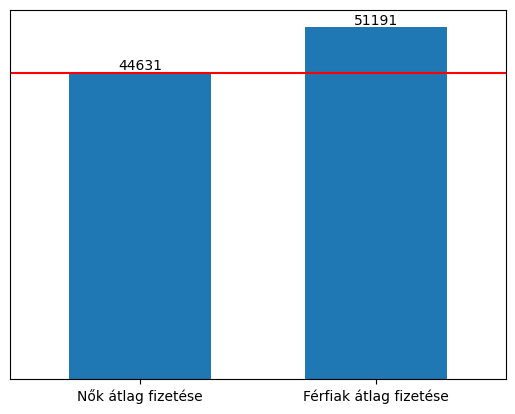

In [22]:
#@title Plot kirajzolása
nem_fizetes_crt=pd.crosstab(mcr.Q9[1:],mcr.Q1[1:])
nem_fizetes_crt=nem_fizetes_crt.iloc[:-1,:-2]
df = nemek_atlag(nem_fizetes_crt)

ax = df.plot(kind="bar", legend=None, width=0.6, rot=0, yticks=[], ylabel='')
ax.bar_label(ax.containers[0])
plt.axhline(y=df.iloc[0,0], color='r', linestyle='-')
plt.show()

## Melyik országban keres a legjobban egy data scientist?

In [23]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
Q3_top5=mcr.groupby("Q3").size().sort_values(ascending=False)[:5].to_dict() # Top 5 legtöbb válasz arra, hogy melyik országban dolgozik
orszag_fizetes_crt = pd.crosstab(mcr.Q9[1:],mcr.Q3[mcr.Q3.isin(Q3_top5)]) # Top 5 ország crosstab-ja a fizetésekkel
sorrend = salary_range_sort(orszag_fizetes_crt.index) # Elnevezések sorba állítása (ugyan azt a function-t használja mint a nem-fizetés összefüggésnél)
orszag_fizetes_crt["sorrend"] = orszag_fizetes_crt.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
orszag_fizetes_crt["sorrend"] = orszag_fizetes_crt["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
orszag_fizetes_crt = orszag_fizetes_crt.sort_values(by="sorrend")

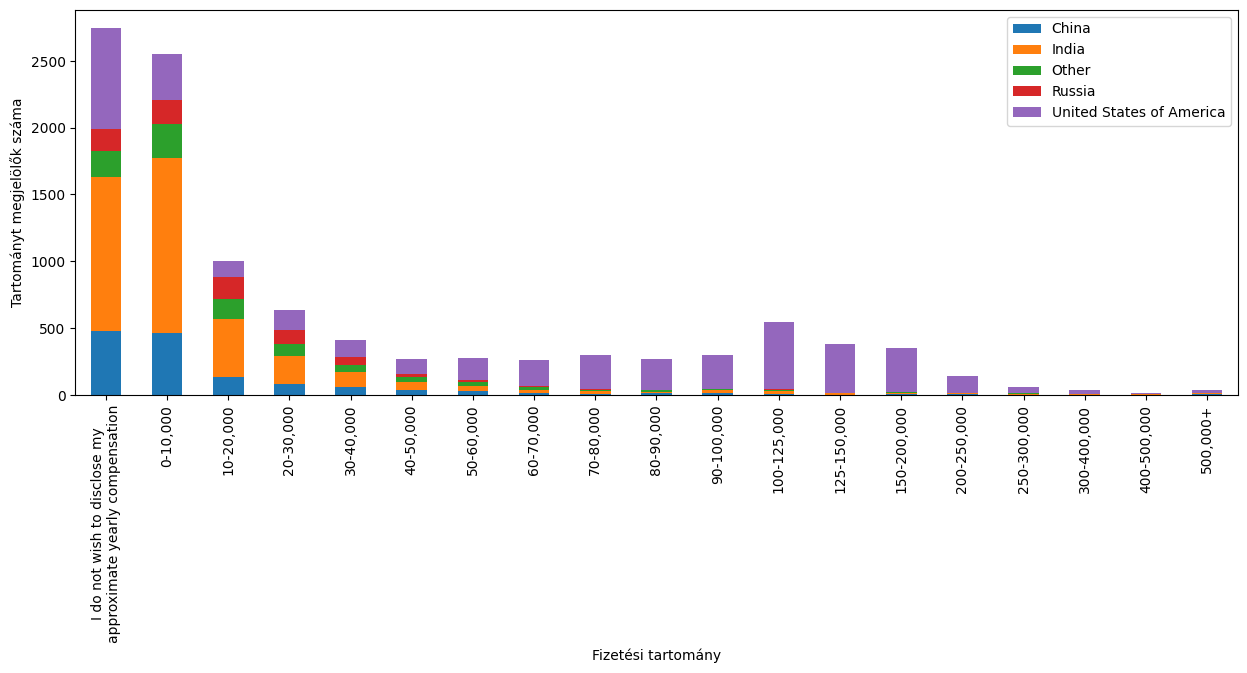

In [24]:
#@title Plot kirajzolása
labels = [textwrap.fill(l,35) for l in orszag_fizetes_crt.index] # Több soros címkék létrehozása
legend = [x for x in orszag_fizetes_crt.columns] 
ax = orszag_fizetes_crt.plot(kind="bar",figsize=(15,5),xlabel="Fizetési tartomány", ylabel="Tartományt megjelölők száma", stacked=True, rot=90) 
ax.set_xticklabels(labels) # Címkék beállítása
ax.legend(legend) # Legend beállítása
plt.show()

## Hogyan folyásolja be az iskolai tanulmányainak tárgya egy data scientist fizetését?

In [25]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
iv_fizetes_crt=pd.crosstab(mcr.Q9[1:],mcr.Q5[1:]) # Fizetések crosstab-ja nemekkel
sorrend = salary_range_sort(iv_fizetes_crt.index) # Elnevezések sorba állítása
iv_fizetes_crt["sorrend"] = iv_fizetes_crt.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
iv_fizetes_crt["sorrend"] = iv_fizetes_crt["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
iv_fizetes_crt = iv_fizetes_crt.sort_values(by="sorrend")
iv_fizetes_crt.drop(columns=iv_fizetes_crt.columns[5:], inplace=True) # Eltekintünk a ritkább adatoktól
iv_fizetes_crt = iv_fizetes_crt.iloc[1:] # Csak számbeli adatokat jelenítünk meg
fizetes_by_iv_list = iv_fizetes_crt.sum(axis=1).tolist()
uj_iv_fizetes_crt = iv_fizetes_crt.div(fizetes_by_iv_list, axis=0)

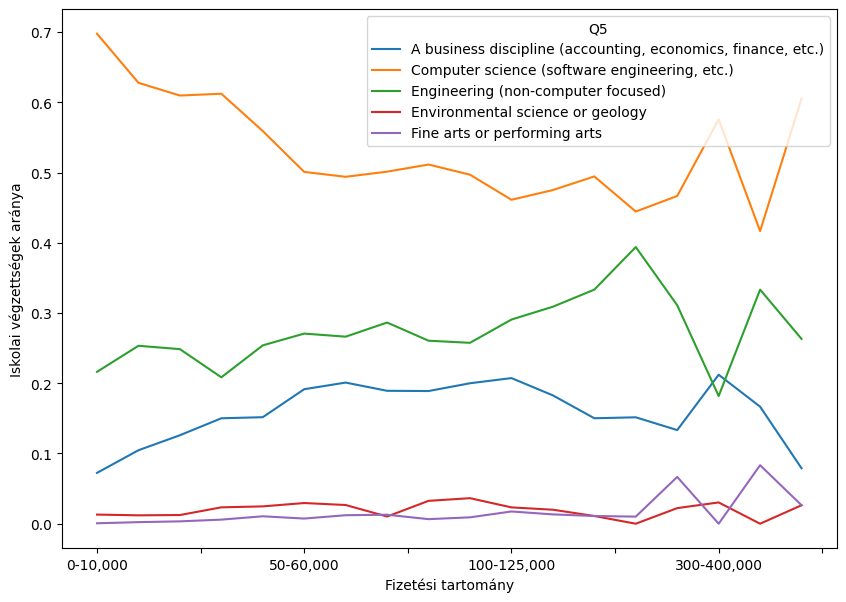

In [26]:
#@title Plot kirajzolása
ax = uj_iv_fizetes_crt.plot(kind="line",figsize=(10,7),xlabel="Fizetési tartomány", ylabel = "Iskolai végzettségek aránya")
plt.show()

## Hogyan folyásolja be az iskolai tanulmányainak típusa egy data scientist fizetését?

In [27]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
ivt_fizetes_crt=pd.crosstab(mcr.Q9[1:],mcr.Q4[1:]) # Fizetések crosstab-ja nemekkel
sorrend = salary_range_sort(ivt_fizetes_crt.index) # Elnevezések sorba állítása
ivt_fizetes_crt["sorrend"] = ivt_fizetes_crt.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
ivt_fizetes_crt["sorrend"] = ivt_fizetes_crt["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
ivt_fizetes_crt = ivt_fizetes_crt.sort_values(by="sorrend")
ivt_fizetes_crt.drop(columns=ivt_fizetes_crt.columns[5:], inplace=True) # Eltekintünk a ritkább adatoktól
ivt_fizetes_crt = ivt_fizetes_crt.iloc[1:] # Csak számbeli adatokat jelenítünk meg
fizetes_by_ivt_list = ivt_fizetes_crt.sum(axis=1).tolist()
uj_ivt_fizetes_crt = ivt_fizetes_crt.div(fizetes_by_ivt_list, axis=0)

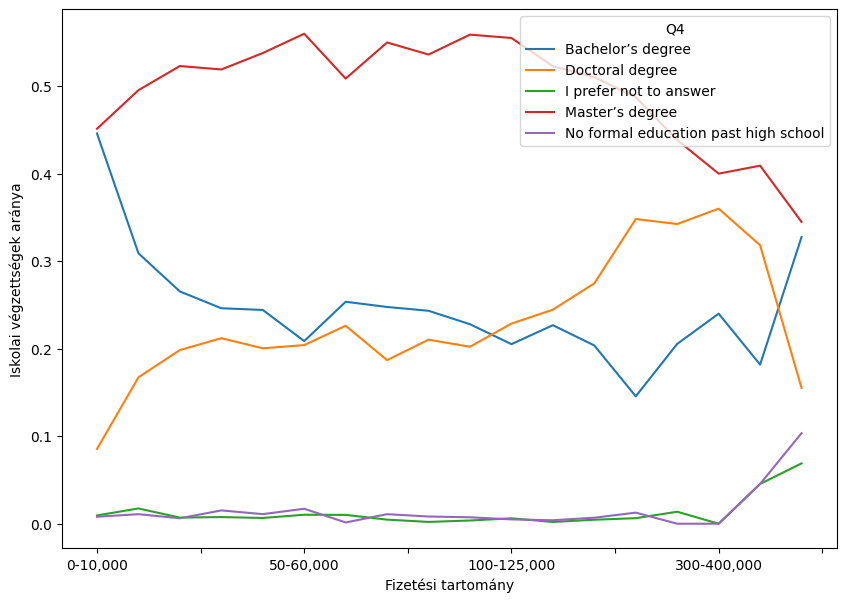

In [28]:
#@title Plot kirajzolása
ax = uj_ivt_fizetes_crt.plot(kind="line",figsize=(10,7),xlabel="Fizetési tartomány", ylabel = "Iskolai végzettségek aránya")
plt.show()

## Milyen iparágban lehet egy data scientist munkáltatója? Ez hogyan befolyásolhatja a fizetését?

In [29]:
#@title Dataframe kialakítása, adatok előkészítése a plot-hoz
mu_fizetes_crt=pd.crosstab(mcr.Q9[1:],mcr.Q7[1:]) # Fizetések crosstab-ja nemekkel
sorrend = salary_range_sort(mu_fizetes_crt.index) # Elnevezések sorba állítása
mu_fizetes_crt["sorrend"] = mu_fizetes_crt.index # Extra oszlop az elnevezések megfelelő sorrendjéhez
mu_fizetes_crt["sorrend"] = mu_fizetes_crt["sorrend"].astype(sorrend) # Elnevezések sorrendjének beállítása
mu_fizetes_crt = mu_fizetes_crt.sort_values(by="sorrend")
mu_fizetes_crt.drop(columns=mu_fizetes_crt.columns[5:], inplace=True) # Eltekintünk a ritkább adatoktól
mu_fizetes_crt = mu_fizetes_crt.iloc[1:] # Csak számbeli adatokat jelenítünk meg
fizetes_by_mu_list = mu_fizetes_crt.sum(axis=1).tolist()
uj_mu_fizetes_crt = mu_fizetes_crt.div(fizetes_by_mu_list, axis=0)

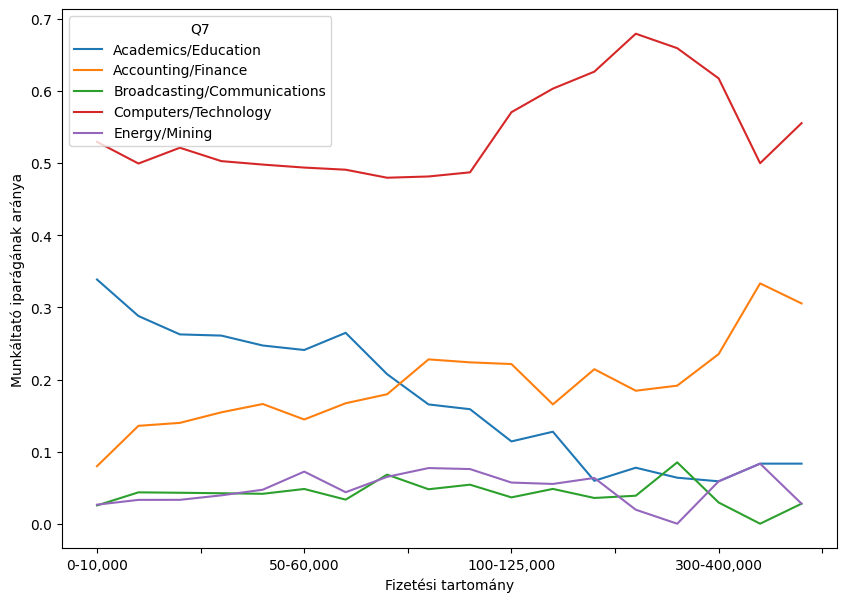

In [30]:
#@title Plot kirajzolása
ax = uj_mu_fizetes_crt.plot(kind="line",figsize=(10,7),xlabel="Fizetési tartomány", ylabel = "Munkáltató iparágának aránya")
plt.show()

## Melyik a fontosabb: az akadémiai eredmények vagy a saját projektek készítése?

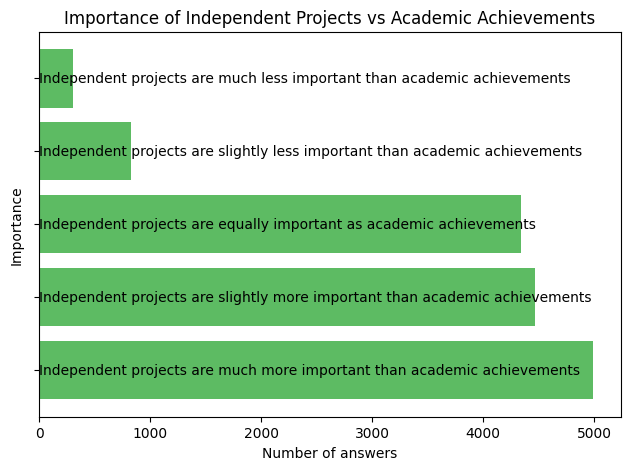

In [31]:
#@title Plot kirajzolása
values = mcr['Q40'][1:].dropna()
values = values[values != 'No opinion; I do not know']


value_counts = dict(values.value_counts())
unique_values = list(value_counts.keys())

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.barh(unique_values, value_counts.values(), tick_label=[None], color='#5DBB63')
for i, v in enumerate(value_counts.values()):
    ax.text(0, i, list(value_counts.keys())[i], ha='left', va='center')

plt.title('Importance of Independent Projects vs Academic Achievements')
plt.xlabel('Number of answers')
plt.ylabel('Importance')

plt.show()

## Milyen programozási nyelvet érdemes elsőként tanulni, ha adattudósok akarunk lenni?

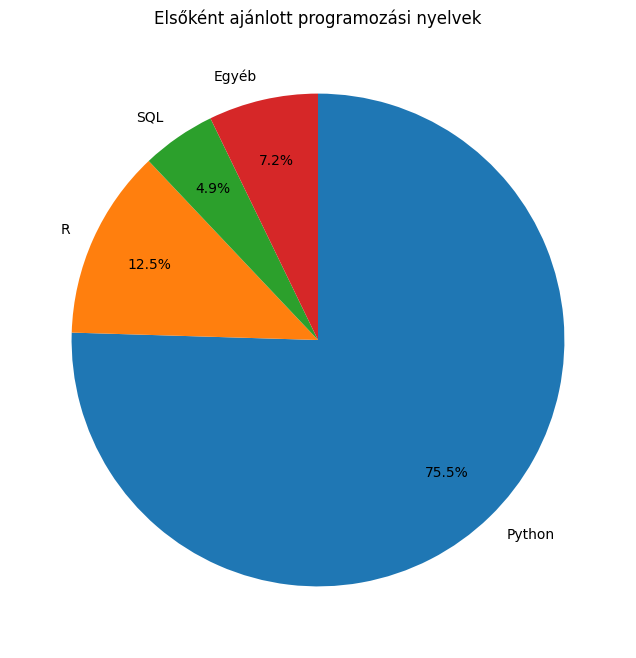

In [32]:
#@title Plot kirajzolása
first_languages_series = mcr['Q18'][1:].dropna()
first_lang_counts = first_languages_series.value_counts()

small_percentages = first_lang_counts[first_lang_counts/len(first_languages_series)*100 < 2]

other_count = small_percentages.sum()
first_lang_counts = first_lang_counts.drop(small_percentages.index)
first_lang_counts['Egyéb'] = other_count

plt.figure(figsize=(8, 8))
first_lang_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.75)
plt.title('Elsőként ajánlott programozási nyelvek')
plt.gca().set_ylabel('')
plt.show()

## Milyen programozási nyelvet használnak az adattudósok a leggyakrabban?

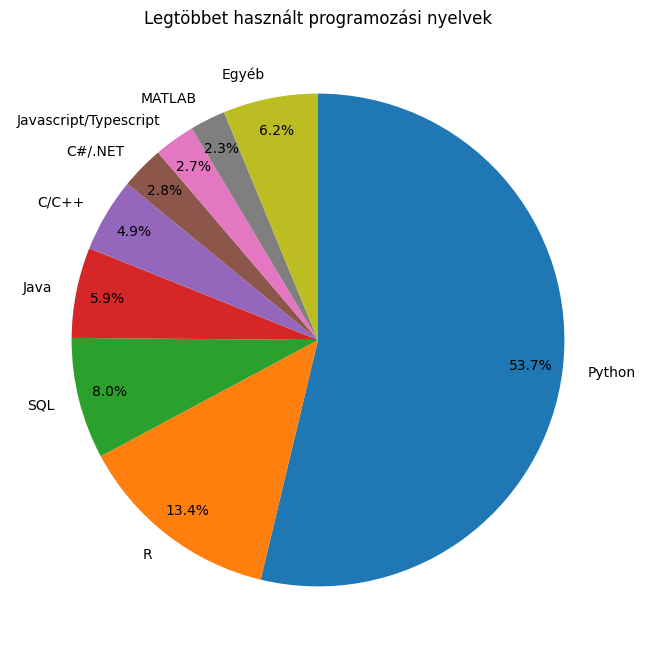

In [33]:
#@title Plot kirajzolása
most_used_languages_series = mcr['Q17'][1:].dropna()
most_used_lang_counts = most_used_languages_series.value_counts()

small_percentages = most_used_lang_counts[most_used_lang_counts/len(most_used_languages_series)*100 < 2]

other_count = small_percentages.sum()
most_used_lang_counts = most_used_lang_counts.drop(small_percentages.index)
most_used_lang_counts['Egyéb'] = other_count

plt.figure(figsize=(8, 8))
most_used_lang_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.87)
plt.title('Legtöbbet használt programozási nyelvek')
plt.gca().set_ylabel('')
plt.show()

##Milyen vizualizációs eszközöket használnak az adattudósok a leggyakrabban?

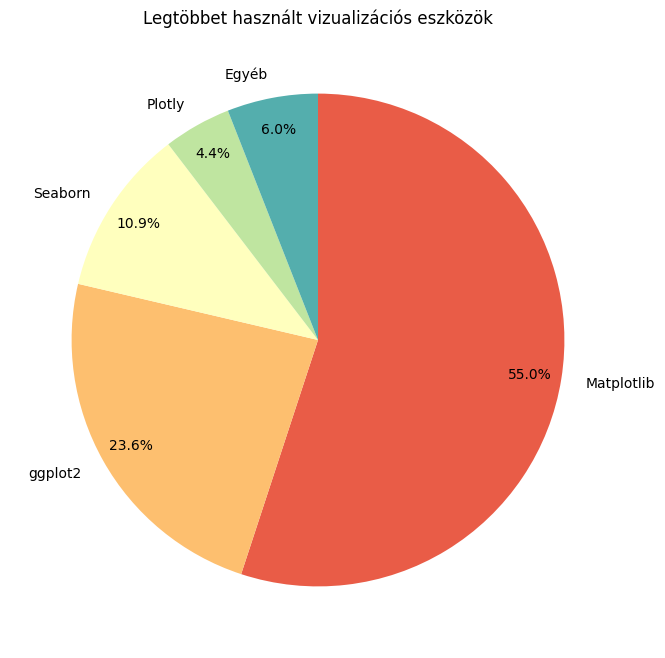

In [34]:
#@title Plot kirajzolása
most_used_vis_tools_series = mcr['Q22'][1:].dropna()
most_used_vis_tools_counts = most_used_vis_tools_series.value_counts()

small_percentages = most_used_vis_tools_counts[most_used_vis_tools_counts/len(most_used_vis_tools_series)*100 < 2]

other_count = small_percentages.sum()
most_used_vis_tools_counts = most_used_vis_tools_counts.drop(small_percentages.index)
most_used_vis_tools_counts['Egyéb'] = other_count

plt.figure(figsize=(8, 8))

colors = sns.color_palette("Spectral", n_colors=5)
labels = most_used_vis_tools_counts.index.tolist()

plt.pie(most_used_vis_tools_counts, colors=colors, labels = labels , autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.87)
plt.title('Legtöbbet használt vizualizációs eszközök')
plt.gca().set_ylabel('')
plt.show()

##Milyen adatokkal dolgoznak általában az adattudósok?

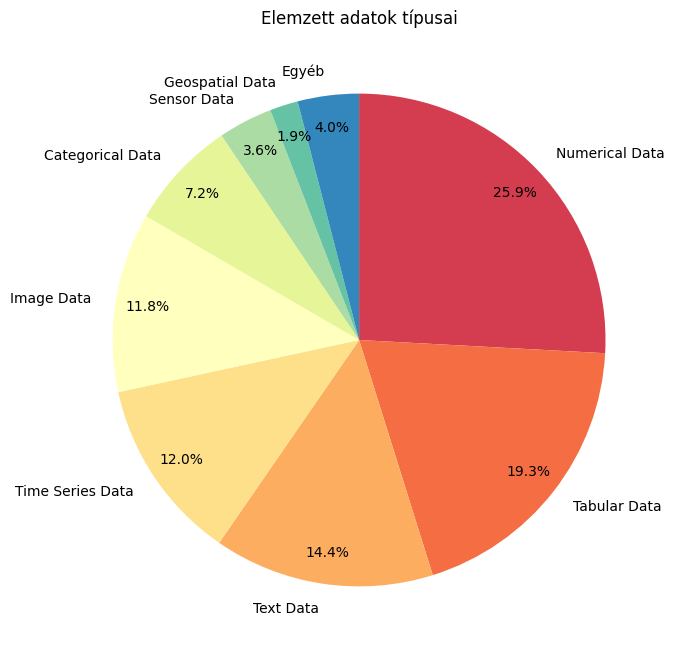

In [35]:
#@title Plot kirajzolása
most_used_data_series = mcr['Q32'][1:].dropna()
most_used_data_counts = most_used_data_series.value_counts()

small_percentages = most_used_data_counts[most_used_data_counts/len(most_used_vis_tools_series)*100 < 2]

other_count = small_percentages.sum()
most_used_data_counts = most_used_data_counts.drop(small_percentages.index)
most_used_data_counts['Egyéb'] = other_count

plt.figure(figsize=(8, 8))

colors = sns.color_palette("Spectral", n_colors=9)
labels = most_used_data_counts.index.tolist()

plt.pie(most_used_data_counts, colors=colors, labels = labels , autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.87)
plt.title('Elemzett adatok típusai')
plt.gca().set_ylabel('')
plt.show()